In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
data = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv', index_col = 0)
#labels = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv')
eigenvalues = pickle.load( open( "eigenvalues_first_800.pkl", "rb" ) )
eigenvectors = pickle.load( open( "eigenvectors_first_800.pkl", "rb" ) )

In [3]:
mean_arr = np.mean(data, 0)
var_arr = np.var(data, 0)
df = data.drop(data.columns[np.argwhere(np.array(var_arr == 0)).flatten()], axis = 1)
mean_arr = np.mean(df, 0)
var_arr = np.var(df, 0)
min_var = 2
df.drop(df.columns[np.argwhere(np.array(var_arr < min_var)).flatten()], axis = 1, inplace = True)
mean_arr = np.mean(df, 0)
var_arr = np.var(df, 0)
df = (df - mean_arr)/(var_arr ** (1/2))
df = np.real(np.array(df@eigenvectors))


In [4]:
from sklearn.cluster import KMeans

n = df.shape[0]
n_subsample_fraction = int(0.8*n)
K_max = 10
K_array = list(range(2,K_max+1))
M = 50
C_arr = np.zeros((len(K_array), n, n))
for i, K in enumerate(K_array):
    M_arr = np.zeros((M,n,n))
    J_arr = np.zeros((M,n,n))
    for m in range(M):
        indices = np.random.choice(np.array(range(n)), n_subsample_fraction, replace = False)
        
        chosen_samples = np.zeros(n)
        chosen_samples[indices] = 1
        J_m = np.reshape(chosen_samples, (-1, 1))@np.reshape(chosen_samples, (1, -1))
        
        current_data = df[indices, :]
        km = KMeans(n_clusters=K, random_state=0, n_init = 1).fit(current_data)
        labels = km.predict(current_data)
        
        connectivity = np.zeros((n_subsample_fraction, n_subsample_fraction))
        for k in range(K):
            samples_with_current_label = labels == k
            connectivity += np.reshape(samples_with_current_label, (-1, 1))@np.reshape(samples_with_current_label, (1, -1))
        
        
        M_m = np.zeros((n,n))
        M_m[np.argwhere(J_m == 1)[:, 0], np.argwhere(J_m == 1)[:, 1]] = connectivity.flatten()
        M_arr[m] = M_m
        J_arr[m] = J_m

    C = M_arr.sum(0)/J_arr.sum(0)
    C_arr[i] = C
        

        

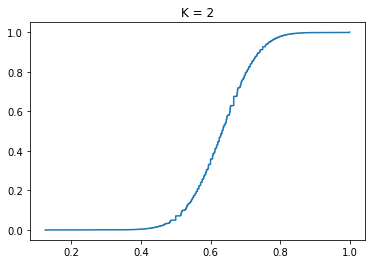

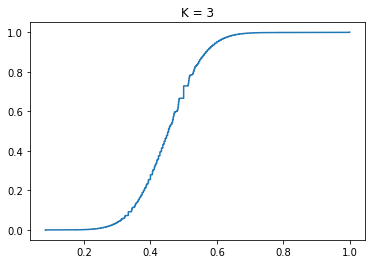

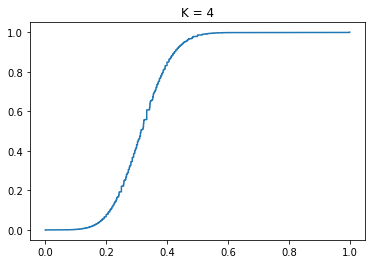

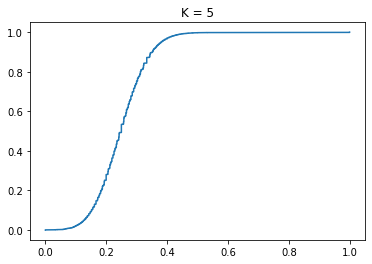

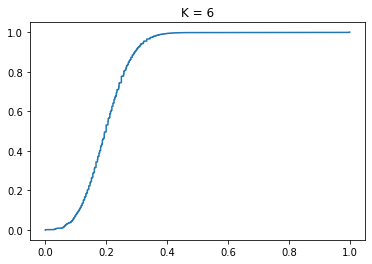

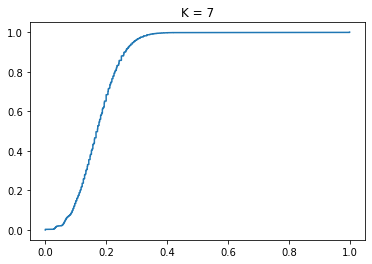

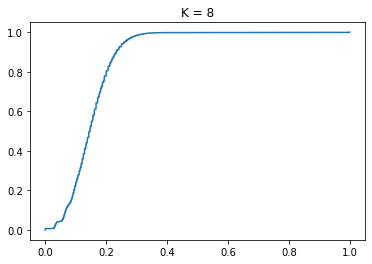

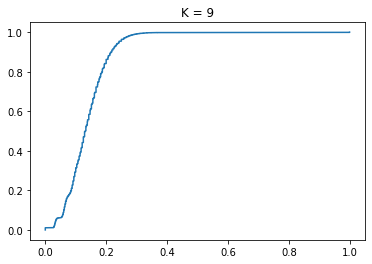

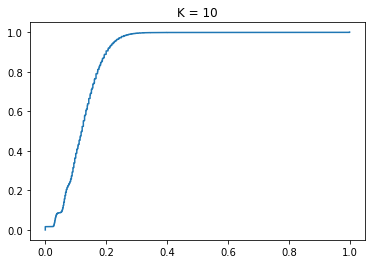

In [24]:
from statsmodels.distributions.empirical_distribution import ECDF
q2 = 0.99
q1 = 0.01

PAC_arr = np.zeros(len(K_array))

for i in range(len(K_array)):
    C = C_arr[i]
    ecdf = ECDF(C.flatten())
    PAC_arr[i] = ecdf.y[np.argwhere(ecdf.x > q2)[0]] - ecdf.y[np.argwhere(ecdf.x > q1)[0]]
    plt.plot(ecdf.x, ecdf.y)
    plt.title("K = %s" % K_array[i])
    plt.show()
    

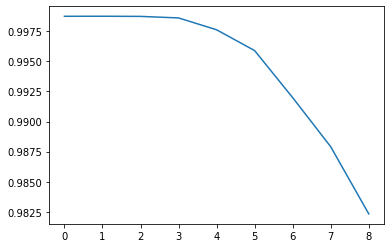

In [25]:

plt.plot(PAC_arr)

[  0   2   3   4   5   6   8   9  10  11  13  14  15  16  20  21  22  23
  24  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44  45
  46  48  49  50  51  52  53  55  57  58  59  60  61  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86
  88  89  90  91  92  93  94  95  97  98  99 100 101 102 104 105 106 107
 108 110 111 112 113 114 115 116 118 119 121 122 124 125 127 128 129 130
 131 133 134 135 136 137 138 139 140 141 142 144 147 148 149 150 151 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 169 170 171 172 173
 175 176 177 178 179 180 181 182 183 184 185 187 190 191 192 193 194 195
 196 197 199 200 201 202 203 204 205 206 207 209 210 211 212 213 214 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 232 233 234 235
 236 237 238 240 241 242 243 244 247 249 250 251 252 253 255 256 257 258
 259 260 261 262 263 265 266 267 268 269 271 272 274 276 277 278 279 282
 283 284 285 286 287 288 290 291 293 294 296 299 30

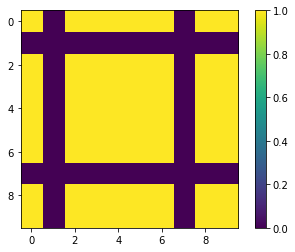

In [35]:
print(np.sort(indices))
plt.imshow(J_m[:10, :10])
plt.colorbar()
plt.show()
